In [46]:
import matplotlib.pyplot as plt
from numba import njit
from math import ceil
import ipywidgets as widgets

from utils import *

In [125]:
@njit
def match(window, inp):
  best_match = 0
  best_match_pos = 0
  for i in range(len(window)):
    i = len(window) - i - 1
    n = 0
    for j in range(len(inp)):
      if i + j >= len(window) or window[i + j] != inp[j]:
        break
      n += 1
    if n > best_match:
      best_match_pos = len(window) - i - 1
      best_match = n
  return (best_match_pos, best_match)

def lz77_size(words, compare_to, max_words):
  i = 0
  size = 0
  while i < len(words) and i < max_words:
    window = compare_to[i:i + 64]
    inp = words[i:min(len(words), i + 4)]
    pos, length = match(window, inp)
    i += max(length, 1)
    size += 9
  return size

def lz77(words):
  i = 1
  size = 0
  lens = np.zeros(128)
  poss = np.zeros(256)
  while i < len(words):
    window = words[max(0, i - 64):i]
    inp = words[i:min(len(words), i + 4)]
    pos, length = match(window.tolist(), inp.tolist())
    i += max(length, 1)
    size += 9
    lens[length] += 1
    #poss[pos] += 1
  plt.plot(lens)
  #plt.plot(poss, label="POs")
  plt.legend()
  plt.show()
  return size

In [53]:
for frame in get_frames(f'data/xpcs.bin'):
  print(lz77(frame.flatten().tolist()))
  print(128*128*10)

/home/sebastian/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'inp' of function 'match'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_977/1198602362.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/sebastian/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'window' of function 'match'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_977/1198602362.py", 

KeyboardInterrupt: 

/home/sebastian/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'inp' of function 'match'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_977/2367915261.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/sebastian/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'window' of function 'match'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_977/2367915261.py", 

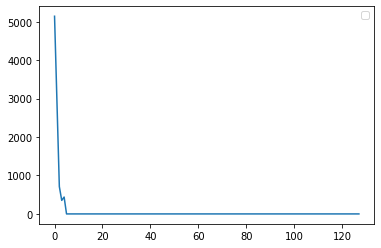

85995
98304


In [131]:
with open("../compressed.bin", 'rb') as file:
  bytess = file.read(128*128*8)
  data = np.frombuffer(bytess, dtype=np.uint8)
  print(lz77(data))
  print(data.shape[0] * 8)

In [110]:
@njit
def dbw_compress(pixels):
  enc_out = np.zeros((64, 10), dtype=np.uint16)
  headers = np.zeros(64, dtype=np.uint16)
  for i in range(64):
    pixs = pixels[4*(i % 2):4*(i % 2) + 4, 4*(i//2):4*(i//2) + 4].flatten().astype(np.uint16)
    for j in range(16):
      for k in range(10):
        enc_out[i][k] += ((pixs[j] & (1 << k)) != 0) << j
    headers[i] = np.ceil(np.log2(np.max(pixs) + 1))
    
  data = np.zeros((64*(16*10 + 6) + 7) // 8, dtype=np.uint8)

  di = 0
  for i in range(64):
    data[i // 4] += (headers[i] if headers[i] <= 2 else 3) << (6 - (i % 4) * 2)
  di += 16
  p = 0
  for i in range(64):
    if headers[i] >= 3:
      data[di + p // 2] += headers[i] << (4 - 4 * (p % 2))
      p += 1
  di += p

  for i in range(64):
    for j in range(headers[i]):
      data[di] = enc_out[i][j] >> 8
      data[di + 1] = enc_out[i][j] & ((1 << 8) - 1)
      di += 2
  return data, di


In [135]:
tot_in = 0
tot_out = 0
lz_in = 0
lz_out = 0
prev = np.zeros((16, 256 + 64), dtype=np.uint8)
prev_lens = np.zeros(16, dtype=np.uint8)
for frame in get_frames(f'data/xpcs.bin'):
  for s_col in range(0, 128, 8):
    shift = frame[s_col:s_col + 8]
    comp, length = dbw_compress(shift)

    tot_in += 64*10*16 // 8
    tot_out += length

    lz_size = lz77_size(comp[0:256], prev[s_col//8], length)
    
    prev[s_col // 8] = comp[0:256 + 64]
    prev_lens[s_col // 8] = length
    #print(length * 8 / lz_size)
    lz_in += length * 8
    lz_out += lz_size

  print(tot_in / tot_out, lz_in / lz_out)

4.642938109272274 1.0380960786044187
4.622503103487191 1.146164791100763
4.611227859501652 1.1977705861201007
4.608979408124227 1.22132893561465
4.616980026150864 1.2375034000795095
4.619722545960374 1.2447252200871575
4.614542762416712 1.2487614683508688
4.614951270350966 1.2539171666600442
4.614575770472924 1.2591725676096355
4.614795286058722 1.265210558388659
4.6148803670927565 1.2673267326732673
4.615644661470561 1.2672402508538312
4.616051458987118 1.2678910981413702
4.618184746718209 1.269563750412171
4.6180905278032505 1.2697785508574264
4.620873464667973 1.270304463388037
4.621490674985067 1.2702869042500273
4.621402065991375 1.2720647450464457
4.62038994039279 1.2717093813821976
4.620104674246526 1.2751053077250836
4.619548872180451 1.2749473194095666
4.619706756895314 1.276403612092658
4.618401443250451 1.2764456959599515
4.619201563792196 1.2761909045252497
4.618937644341801 1.2747798061345212
4.621219353438923 1.2752882126458012
4.620552500960944 1.2722529856468359
4.63449

In [133]:
tot_in = 0
tot_out = 0
lz_in = 0
lz_out = 0
prev = np.zeros(64, dtype=np.uint8)
for frame in get_frames(f'data/xpcs.bin'):
  for s_col in range(0, 128, 8):
    shift = frame[s_col:s_col + 8]
    comp, length = dbw_compress(shift)

    tot_in += 64*10*16 // 8
    tot_out += length

    lz_size = lz77_size(comp[0:256], np.concatenate((prev, comp[0:256])), length)
    
    if length < 64:
      prev = np.concatenate((prev[length:], comp[:length]))
    else:
      prev = comp[length - 64:length]
    #print(length * 8 / lz_size)
    lz_in += length * 8
    lz_out += lz_size

  print(tot_in / tot_out, lz_in / lz_out)

8.14314115308151 1.1741363211951448
8.241448692152918 1.1644116441164412
8.266953713670613 1.1626579060581173
8.301580867450344 1.1576554778349684
8.272741961544677 1.1595180384304633
8.289260658391797 1.155563350775137
8.260919672697938 1.1558352898080158
8.258064516129032 1.1551421730238787
8.266582948378705 1.1552550452060828
8.272741961544677 1.155681599355776
8.265032835601863 1.1561027076606596
8.267788057190916 1.1546660063025924
8.27577632028846 1.1553185376714787
8.27761418095733 1.154802090365814
8.282109349725008 1.1544755301889655
8.283533040093028 1.1537822111388196
8.27592764268226 1.1540495221635856
8.268993517417734 1.153976574128001
8.26718789835982 1.1558158523184214
8.271906617929195 1.154767318478096
8.274906684111286 1.1552377062616868
8.276571512546383 1.1554557972571775
8.277655742026184 1.1555575862340306
8.278928751894897 1.1555866981985927
8.283583296930868 1.1553947958725885
8.286594665255688 1.1553038475368573
8.28379674017258 1.1545817577223854
8.2897000361